<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/LearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 50 (delta 16), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (50/50), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


In [2]:
import numpy as np
import torch
import models
import copy
import torch.nn.functional as F

# **Loading pytorch "Google Speech Commands" dataset.**

We need new novel classes to train our pre-trained neural network further in order to test the Learning without Forgetting algorithm. As a result, in addition to our existing dataset of spoken digits, we are using Google's "Speech Commands" dataset to train new spoken words.

[Here is the pytorch link](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html)  

[Here is the research paper link](https://arxiv.org/abs/1804.03209)


In [3]:
import torchaudio

dataset = torchaudio.datasets.SPEECHCOMMANDS('./dataset/data/' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

"Speech Commands" dataset is consist of 35 commands spoken by different people. Almost all samples have 16KHz sampling rate. Here is the list of all spoken words.

In [4]:
labels = sorted(list(set(datapoint[2] for datapoint in dataset)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

# **Data Preprocessing **
We must now preprocess our dataset. As of now, we are only considering three randomly chosen words as Novel classes (e.g., 'right,' 'down,' and 'yes').


*   First, we must merge the old class list (e.g., 1,2,3,...) with the new class list.


*   To convert labels to integer indexes and vice versa, we have two methods: "label to index" and "index to label."


*   Then, using your Pytorch MFCC transforms, we will convert a 16KHz waveform to an MFCC. The MFCC will be used in neural network training to extract low level audio feature from a waveform.

*   Adjust the paramerters for the MFCC transform in a way that it will result into tensor of shape ([1, 32, 32]). Tensor with different shape will create problem in a model


In [5]:
random_targets = ['right', 'down', 'yes']
print(f"Randomly selected tagets: {random_targets}")

digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'nodigit']
labels = digits + random_targets
print(f"List of all target classes: {labels}")

def label_to_index(labels, label):
    # Return the position of the word in labels
    return torch.tensor(labels.index(label))

def index_to_label(labels, index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

tensors = []
targets = []

#parameters for MFCC transformation
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

for waveform, sample_rate, label, *_ in dataset:
  if label in random_targets:
    if sample_rate == 16000:
      if waveform.shape == (1, 16000):
        tensors += [torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=32, 
                                               melkwargs={
                                                            'n_fft': n_fft,
                                                            'n_mels': n_mels,
                                                            'hop_length': hop_length,
                                                            'mel_scale': 'htk',
                                                          }
                                                          )(waveform)]
        targets += [label_to_index(labels, label)]

print(f"indext for selected targets: {label_to_index(labels, random_targets[0])} , {label_to_index(labels, random_targets[1])}, {label_to_index(labels, random_targets[2])}")
print(len(tensors))
print(len(targets))
print(f"Shape of waveform after MFCC wit n_mfcc=32: {tensors[0].shape}")

Randomly selected tagets: ['right', 'down', 'yes']
List of all target classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'nodigit', 'right', 'down', 'yes']
indext for selected targets: 11 , 12, 13
10720
10720
Shape of waveform after MFCC wit n_mfcc=32: torch.Size([1, 32, 32])


In [38]:
import IPython.display as idp
#extract and analyse single sample from dataset
#we are here only concerned about waveform, sampling rate and spoken word/label of a sample
waveform, sample_rate, label, *_ =  dataset[1]

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256
sample = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=32,
                                    melkwargs={
                                                'n_fft': n_fft,
                                                'n_mels': n_mels,
                                                'hop_length': hop_length,
                                                'mel_scale': 'htk',
                                              }
                                              )(waveform)

print(f"Shape after MFCC transforms: {sample.shape}")
print(f"Sampling rate of a waveform: {sample_rate}")
print(f"Label of a sample: {label}")
print(f"Shape of a waveform: {waveform.squeeze().shape}")

#play sample waveform
idp.Audio(waveform.numpy(), rate=sample_rate)

Shape after MFCC transforms: torch.Size([1, 32, 32])
Sampling rate of a waveform: 16000
Label of a sample: backward
Shape of a waveform: torch.Size([16000])


# **Pytorch custom Dataset and Dataloader:**

We need custom dataset and dataloader for training pipeline.

Finally, we will visualize single batch(one iteration of dataloader) of low level features i.e MFCC of waveforms.


In [39]:
from torch.utils.data import Dataset

class SpeechCommandSubDataset(Dataset):
    
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [40]:
from torch.utils.data import DataLoader,random_split,Dataset

valid_dataset = SpeechCommandSubDataset(tensors, targets)
traindata, testdata = random_split(valid_dataset, [round(len(valid_dataset)*.8), round(len(valid_dataset)*.2)])

trainloader = DataLoader(traindata, batch_size=5, shuffle=True)
testloader = DataLoader(testdata, batch_size=5, shuffle=True)

Feature batch shape: torch.Size([5, 1, 32, 32])
Labels batch shape: torch.Size([5])


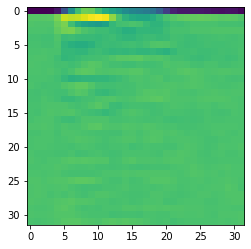

torch.Size([32, 32])
Label: 13


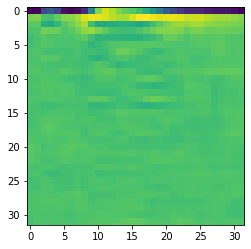

torch.Size([32, 32])
Label: 12


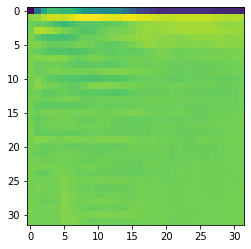

torch.Size([32, 32])
Label: 12


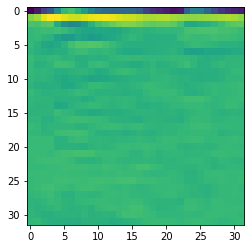

torch.Size([32, 32])
Label: 12


In [41]:
# Display image and label.
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")

img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")

img = train_features[2].squeeze()
label = train_labels[3]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")

img = train_features[3].squeeze()
label = train_labels[3]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")
# grid = make_grid(train_features)
# show(grid)

# **Pytorch Model:**

We will use pre-trained model and it's saved state to further train model. 

Later on, as mentioned in the Learning without Forgetting research paper, we will add novel classes at the end linear layer (fc3 layer). We will initalize Novel class weights with kaiming initilaization.  [Pytorch link for kaiming initialization](https://pytorch.org/docs/stable/nn.init.html). 

It is recommended in the paper to use xavier initialization to initialize weights, but this method is better suited for layers with sigmoid activation, whereas kaiming initialization is better suited for layers with relu activation function. As a result, we've used kaiming instead of xavier here.

In [ ]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device is: {device}")
model = models.cnnModel()
pretrained_model_path = "./savedmodels/best_model_state.pt"
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

#add new class parameters , here we have added 3 new classes
input_features = model.fc3.in_features
output_features = model.fc3.out_features
print(f"Pre-trained model input features: {input_features}")
print(f"Pre-trained model output features: {output_features}")

params = list(model.parameters())
print(f"Number of total parameters used in a network: {len(params)}")
print(f"Old model: {model}")

#save fc3 layers weights for initialization step
old_weights = copy.deepcopy(model.fc3.weight.data)  #torch.Size([11, 256])
print(f"weights before addition of new classes {model.fc3.weight.data}")
print(f"weights shape before addition of new classes {model.fc3.weight.data.shape}")

#consider len(random_targets) = 3 here 
# new_output_features = output_features + len(random_targets)
new_output_features = output_features + 3
print(f"new output features: {new_output_features}")

model.fc3 = nn.Linear(in_features=input_features, out_features= new_output_features)
input_features_new = model.fc3.in_features
output_features_new = model.fc3.out_features
print(f"New model input features: {input_features_new}")
print(f"New model output features: {output_features_new}")

#Initialize new weights with kaiming normal distribution 
# in paper xaviour is suggested for relu kaiming is recommended
print(f"weights before initialization: {model.fc3.weight.data}")
print(f"weights shape before initialization: {model.fc3.weight.data.shape}")
nn.init.kaiming_normal_(model.fc3.weight, nonlinearity='relu')
print(f"weights after initialization: {model.fc3.weight.data}")
print(f"weights shape after initialization: {model.fc3.weight.data.shape}")
#copy old weights
model.fc3.weight.data[:output_features] = old_weights
print(f"weights after coping with old weights: {model.fc3.weight.data}")

params = list(model.parameters())
print(f"Number of total parameters used in a network: {len(params)}")
print(f"New model; {model}")
next(model.parameters()).device

Selected device is: cpu
Pre-trained model input features: 256
Pre-trained model output features: 11
Number of total parameters used in a network: 8
Old model: Net(
  (conv): Conv2d(1, 512, kernel_size=(16, 16), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=11, bias=True)
)
weights before addition of new classes tensor([[ 2.3131e-02,  2.3777e-02,  2.9812e-02,  ...,  1.5164e-02,
         -1.3745e-02,  7.5025e-02],
        [ 2.3959e-02, -1.8836e-02,  3.6962e-02,  ...,  1.1413e-02,
         -2.0814e-02,  1.0763e-01],
        [ 2.4539e-02, -7.1667e-03,  5.4329e-02,  ..., -1.3159e-02,
          2.3648e-03,  3.3104e-02],
        ...,
        [-2.4916e-02, -2.9496e-02,  1.6009e-02,  ..., -6.4058e-03,
         -1.3635e-02, -9.31

device(type='cpu')

In [ ]:
conv1 = nn.Conv2d(1, 512, kernel_size=(16, 16), stride=(1, 1))
logits = F.leaky_relu(conv1(train_features))
print(f"Shape after conv layer 1: {logits.shape}")
pool = nn.MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
logits = pool(logits)
print(f"Shape after max_pool conv layer 1: {logits.shape}")
drop = nn.Dropout(p=0.25)
logits = drop(logits)
print(f"Shape after drop: {logits.shape}")
# print(f"shape of 1D converted logits to pass to Linear layer further: {torch.flatten(logits).shape}")
#
logits = logits.view(logits.size(0),-1)
# fc1 = nn.Linear(in_features=512*2*8, out_features=1024, bias=True). # in case of input([1, 32, 81])
fc1 = nn.Linear(in_features=2048, out_features=1024, bias=True)
logits  = F.leaky_relu(fc1(logits))
print(f"Shape after fc1: {logits.shape}")

fc2 = nn.Linear(in_features=1024, out_features=256, bias=True)
logits = drop(logits)
logits = F.leaky_relu(fc2(logits))
print(f"Shape after fc2: {logits.shape}")

fc3 = nn.Linear(in_features=256, out_features=14, bias=True)
logits = fc3(logits)
print(f"Shape after fc3: {logits.shape}")

#todo: change 11 to 10 classes for pre-trained model

Shape after conv layer 1: torch.Size([5, 512, 17, 17])
Shape after max_pool conv layer 1: torch.Size([5, 512, 2, 2])
Shape after drop: torch.Size([5, 512, 2, 2])
Shape after fc1: torch.Size([5, 1024])
Shape after fc2: torch.Size([5, 256])
Shape after fc3: torch.Size([5, 14])


# **Cross Entropy loss and Distillation loss**:



In pytorch nn.crossEntropyLoss already applied softmax function:

nn.crossEntropyLoss = nn.LogSoftmax + nn.NLLLoss

therefore, no sofmax in last layer and y_actual should be one hot encoded and logits should be raw from linera layer

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset


#lets try with creating functions from scratch
T = 1
def softmax(logits):
  return np.exp(logits/T)/np.sum(np.exp(logits/T), axis=0)

x = np.array([2.0, 1.0, 0.1])
y_pred = softmax(x)
print(f"softmax output with numpy: {y_pred}")

#in pytorch
x = torch.tensor([[2.0, 1.0, 0.1], [3.0, 1.0, 0.1]])
y_pred = torch.softmax(x/T, dim=0)
print(f"softmax output with pytorch: {y_pred}")

#3d tensor softmax
x = torch.tensor([[[2.0, 1.0, 0.1], [1.0, 1.0, 0.1]], [[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]]])
print(f"shape of tensor {x.shape}")
y_pred = torch.softmax(x/T, dim=0)
print(f"softmax output with pytorch for 3D tensor in dim 0: {y_pred}")
y_pred = torch.softmax(x/T, dim=1)
print(f"softmax output with pytorch for 3D tensor in dim 1: {y_pred}")
y_pred = torch.softmax(x/T, dim=2)
print(f"softmax output with pytorch for 3D tensor in dim 2: {y_pred}")
#Cross entropy
def cross_entropy(actual, predicted):
  #predicted should be softmax of logits
  #actual should be one hot encoded
  loss = -np.sum(actual * np.log(predicted))
  return loss #not normalized

x = np.array([2.0, 1.0, 0.1])
y_actual = np.array([0, 1, 0])
loss = cross_entropy(y_actual, softmax(x))
print(f"cross entropy loss with numpy: {loss}")

#in pytorch
#x should be of size nsamples x nclasses (1x3)
x = torch.tensor([[2.0, 1.0, 0.1]])
y_actual = torch.tensor([1]) #no hot encoded , only pass index of the class
loss = nn.CrossEntropyLoss()
l = loss(x, y_actual)
print(f"cross entropy loss with pytorch: {l.item()}")


#Distillation loss
##temerature value decide how much weight should give to smaller propabilities
##hight T value higher weightage to smaller probabilities 
T = 2
y_pred = F.softmax(x/T, dim=1)
print(f"softmax output with pytorch functional: {y_pred}")


def knowledge_distillation_loss(old_logits, updated_logits, T):
  prob_old_logits = F.softmax(old_logits/T, dim=1)
  print(prob_old_logits.shape)
  log_prob_updated_logits = F.softmax(updated_logits/T, dim=1)
  print(log_prob_updated_logits.shape)
  dist_loss = - (prob_old_logits * log_prob_updated_logits).sum(dim=1)
  print(dist_loss.shape)
  dist_loss = dist_loss.mean()
  return dist_loss

#e.g 3 classes --> 3 labels of tensor size([3])
old_logits = torch.rand(5,11)
updated_logits = torch.rand(5,11)
T = 1
kd_loss = knowledge_distillation_loss(old_logits, updated_logits, T)
print(f"Knowledge distillation: {kd_loss} ")

softmax output with numpy: [0.65900114 0.24243297 0.09856589]
softmax output with pytorch: tensor([[0.2689, 0.5000, 0.5000],
        [0.7311, 0.5000, 0.5000]])
shape of tensor torch.Size([2, 2, 3])
softmax output with pytorch for 3D tensor in dim 0: tensor([[[0.5000, 0.5000, 0.5000],
         [0.2689, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.7311, 0.5000, 0.5000]]])
softmax output with pytorch for 3D tensor in dim 1: tensor([[[0.7311, 0.5000, 0.5000],
         [0.2689, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]]])
softmax output with pytorch for 3D tensor in dim 2: tensor([[[0.6590, 0.2424, 0.0986],
         [0.4155, 0.4155, 0.1689]],

        [[0.6590, 0.2424, 0.0986],
         [0.6590, 0.2424, 0.0986]]])
cross entropy loss with numpy: 1.4170300162778335
cross entropy loss with pytorch: 1.4170299768447876
softmax output with pytorch functional: tensor([[0.5017, 0.3043, 0.1940]])
Knowledge distillation: -0.0894925743

In [ ]:
tensor1 = torch.rand(2,5)
tensor2 = torch.rand(2,5)
print(f"tensor1 : {tensor1}")
print(f"tensor1 : {tensor2}")
print(f"addition: {tensor1 + tensor2}")
tensor = torch.rand(2, 3, 4,5)
print(tensor)
tensor3 = torch.tensor([[[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]] ,[[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]]])
print(tensor3.shape)

tensor1 : tensor([[0.4121, 0.0814, 0.6294, 0.6830, 0.7091],
        [0.2044, 0.4821, 0.0080, 0.2398, 0.6811]])
tensor1 : tensor([[0.2781, 0.0638, 0.1684, 0.3694, 0.7510],
        [0.1884, 0.6669, 0.6748, 0.9250, 0.4021]])
addition: tensor([[0.6903, 0.1452, 0.7978, 1.0523, 1.4601],
        [0.3928, 1.1490, 0.6827, 1.1647, 1.0832]])
tensor([[[[0.9701, 0.6414, 0.0139, 0.3798, 0.2563],
          [0.0616, 0.7785, 0.3423, 0.2857, 0.6295],
          [0.9482, 0.2272, 0.9472, 0.0610, 0.4925],
          [0.9717, 0.2479, 0.0136, 0.9388, 0.4949]],

         [[0.0206, 0.6370, 0.0084, 0.0033, 0.1794],
          [0.0740, 0.2726, 0.1993, 0.0696, 0.7359],
          [0.5071, 0.7440, 0.4200, 0.1331, 0.7226],
          [0.8211, 0.2407, 0.9742, 0.3744, 0.3853]],

         [[0.1420, 0.6136, 0.3525, 0.2356, 0.8280],
          [0.4736, 0.7279, 0.9201, 0.7615, 0.9052],
          [0.2509, 0.4007, 0.6267, 0.0033, 0.7524],
          [0.8290, 0.1768, 0.5954, 0.9816, 0.9369]]],


        [[[0.9215, 0.9197, 0.5631, 

In [ ]:
x = torch.tensor([2.0, 1.0, 0.1])
print(x.shape)
x = torch.tensor([[2.0, 1.0, 0.1]])
print(x.shape)
x = torch.tensor([2])
print(x.shape)
x = torch.tensor([[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]])
print(x.shape)

torch.Size([3])
torch.Size([1, 3])
torch.Size([1])
torch.Size([2, 3])


In [ ]:
import numpy as np
import torch
import models
import copy
import torch.nn.functional as F
import torchaudio
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset


def knowledge_distillation_loss(old_logits, updated_logits, T=1):
  prob_old_logits = F.softmax(old_logits/T, dim=1)
  # print(prob_old_logits.shape)
  log_prob_updated_logits = F.softmax(updated_logits/T, dim=1)
  # print(log_prob_updated_logits.shape)
  dist_loss = - (prob_old_logits * log_prob_updated_logits).sum(dim=1)
  # print(dist_loss.shape)
  dist_loss = dist_loss.mean()
  return dist_loss


def label_to_index(labels, label):
    # Return the position of the word in labels
    return torch.tensor(labels.index(label))

def index_to_label(labels, index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

class SpeechCommandSubDataset(Dataset):
    
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels
        # self.label_dict = list_dir
        # self.transform = transform
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

class learningWithoutForgetting(object):
    def __init__(self, pretrained_model_path, optimizer = 'SGD', num_epochs = 10):
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # load model
        print("Loading the pre-trained model...")
        self.model = models.cnnModel()
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
        # Loss function and optimizer
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

    def evaluate_model(self, X_test, y_test):
        """ Evaluate the model's performance on the test set X_test and y_test

        Parameters:
        ----------
        X_test: torch tensor of MFCC
        y_test: torch tensor of labels

        Returns:
        -------
        accuracy: average accuracy of the model
        accuracies: array of accuracy for each class
        """
        accuracy = 0  # average accuracy of the model
        accuracies = np.zeros(10)  # accuracy for each class
        nb_occurences = np.zeros(10)  # to convert counts to accuracy

        with torch.no_grad():
            for i in range(len(X_test)):
                prediction = self.model.predict(X_test[i].unsqueeze(0).to(device=self.device, dtype=torch.float))
                label = (int)(y_test[i].to(device= self.device).item())
                if prediction == label:
                    accuracies[label] = accuracies[label] + 1
                    accuracy = accuracy + 1 
                nb_occurences[label] = nb_occurences[label] + 1

        accuracy = accuracy / len(X_test)
        accuracies = np.divide(accuracies, nb_occurences)

        return accuracy, accuracies

    def addNovelClassesToModel(self, noNovelClasses):
      #add new novel classes to pre-trained model
      #add new class parameters , here we have added 3 new classes
      input_features = self.model.fc3.in_features
      output_features = self.model.fc3.out_features
      print(f"Old model: {self.model}")

      #save fc3 layers weights for initialization step
      old_weights = copy.deepcopy(self.model.fc3.weight.data)  #torch.Size([11, 256])

      new_output_features = output_features + noNovelClasses
      print(f"new output features: {new_output_features}")

      self.model.fc3 = nn.Linear(in_features=input_features, out_features= new_output_features)

      #Initialize new weights with kaiming normal distribution 
      # in paper xaviour is suggested for relu kaiming is recommended
      nn.init.kaiming_normal_(self.model.fc3.weight, nonlinearity='relu')
      #copy old weights
      self.model.fc3.weight.data[:output_features] = old_weights

      input_features = self.model.fc3.in_features
      output_features = self.model.fc3.out_features
      print(f"New model input features: {input_features}")
      print(f"New model output features: {output_features}")

      # params = list(model.parameters())
      # print(f"Number of total parameters used in a network: {len(params)}")
      print(f"New model; {self.model}")

      #initialize new weights with something ***
      return 

      
    def train(self, train_loader, test_loader):
        best_accuracy = 0.0
        print("Started adaptation of a model !")
        prev_model = copy.deepcopy(self.model)
        #todo : add novel classes to pre-trained model
        self.addNovelClassesToModel(noNovelClasses = len(random_targets))
        self.model.to(self.device)
        print(f"Model is on {next(model.parameters()).device} device")
        for epoch in range(self.num_epochs):
          for i, (inputs, labels) in enumerate(train_loader):          
            # input = input.unsqueeze(1).float().to(self.device)
            # label = label.unsqueeze(0).long().to(self.device)
            self.model.train()
            running_loss = 0.0
            self.optimizer.zero_grad()
            logits = self.model(inputs) #batch_size x 14
            loss_new = F.cross_entropy(logits, labels)
            #calculate old loss
            #todo: check no of in_features in liner layer, because we are passing new data here 
            old_logits = prev_model(inputs)
            loss_old = knowledge_distillation_loss(old_logits=old_logits, 
                                                   updated_logits=logits[:, :-3],
                                                   T=2) # updates logits of size batch_size x 11 (only old logits)
            total_loss = 1*loss_old + loss_new ##todo: what ablout regularization term?
            # print(f'Epoch: {epoch}, total loss: {total_loss}')
            total_loss.backward()
            self.optimizer.step()
        
          #validation loss
          with torch.no_grad():
            valid_loss = 0.0
            self.model.eval()     # Optional when not using Model Specific layer
            for i, (inputs, labels) in enumerate(test_loader):
                # if torch.cuda.is_available():
                #     data, labels = data.cuda(), labels.cuda()
                loagits = self.model(inputs)
                # Find the Loss
                loss = F.cross_entropy(logits,labels)
                # Calculate Loss
                valid_loss += loss.item()
            print(f"Epoch: {epoch}, Validation loss: {valid_loss}")

    def test(self, test_loader):
        self.accuracy, self.accuracies = self.evaluate_model(inputs, labels)
        return

In [ ]:
#Loading dataset and custom dataloader
dataset = torchaudio.datasets.SPEECHCOMMANDS('./dataset/data/' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)

random_targets = ['right', 'down', 'yes']
print(f"Novel tagets: {random_targets}")

# nodigit added because we have 11 classes in our pre-trained model: last one is for nondigits
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'nodigit'] 
labels = digits + random_targets
print(f"List of all target classes: {labels}")

tensors = []
targets = []
#parameters for MFCC transformation
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

for waveform, sample_rate, label, *_ in dataset:
  if label in random_targets:
    if sample_rate == 16000:
      if waveform.shape == (1, 16000):
        tensors += [torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=32, 
                                               melkwargs={
                                                            'n_fft': n_fft,
                                                            'n_mels': n_mels,
                                                            'hop_length': hop_length,
                                                            'mel_scale': 'htk',
                                                          }
                                                          )(waveform)]
        targets += [label_to_index(labels, label)]
        if len(tensors) >= 50:
          #need only few samples for fast training
          print(f"length of tensors : {len(tensors)}")
          break

#taking small amount of sample data for training and testing
valid_dataset = SpeechCommandSubDataset(tensors, targets)
traindata, testdata = random_split(valid_dataset, [round(len(valid_dataset)*.8), round(len(valid_dataset)*.2)])
trainloader = DataLoader(traindata, batch_size=5, shuffle=True)
testloader = DataLoader(testdata, batch_size=5, shuffle=True)

#Model 
FILE_PATH = "./savedmodels/best_model_state.pt"

lwf_obj = learningWithoutForgetting(pretrained_model_path=FILE_PATH, num_epochs=2)
# lwf_obj.train(trainloader)
# lwf_obj.test(testloader)

# print(lwf_obj.accuracy)

Novel tagets: ['right', 'down', 'yes']
List of all target classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'nodigit', 'right', 'down', 'yes']
length of tensors : 50
Loading the pre-trained model...


In [ ]:
lwf_obj.train(train_loader=trainloader, test_loader=testloader)

Started adaptation of a model !
Old model: Net(
  (conv): Conv2d(1, 512, kernel_size=(16, 16), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=11, bias=True)
)
new output features: 14
New model input features: 256
New model output features: 14
New model; Net(
  (conv): Conv2d(1, 512, kernel_size=(16, 16), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=14, bias=True)
)
Model is on cpu device
Epoch: 0, Validation loss: 0.0
Epoch: 1, Validation loss: 0.0


50